<a href="https://colab.research.google.com/github/hawa1983/DATA-602/blob/main/DATA_608_HW2_Modeling_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import yaml
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates  # Import mdates for correct date formatting

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date
start_date = '1998-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to fetch data from FRED API
def fetch_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'])
        return df[['date', 'value']]
    else:
        raise Exception(f"Error fetching {series_id} data: {response.status_code}")

# Fetch CPI, Unemployment, and Fed Funds Rate data
cpi_data = fetch_fred_data('CPIAUCSL', api_key, start_date, end_date)
unemployment_data = fetch_fred_data('UNRATE', api_key, start_date, end_date)
fedfunds_data = fetch_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for easier handling
cpi_data.rename(columns={'value': 'CPI'}, inplace=True)
unemployment_data.rename(columns={'value': 'Unemployment_Rate'}, inplace=True)
fedfunds_data.rename(columns={'value': 'FEDFUNDS'}, inplace=True)

# Calculate YoY Percentage Change for CPI and Unemployment
cpi_data['YoY_Change_CPI'] = cpi_data['CPI'].pct_change(periods=12) * 100
unemployment_data['YoY_Change_Unemployment'] = unemployment_data['Unemployment_Rate'].pct_change(periods=12) * 100

# Merge the data
merged_df = pd.merge(cpi_data[['date', 'YoY_Change_CPI']], unemployment_data[['date', 'YoY_Change_Unemployment']], on='date')
merged_df = pd.merge(merged_df, fedfunds_data[['date', 'FEDFUNDS']], on='date')

# Normalize using Min-Max scaling
scaler = MinMaxScaler()
merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']] = scaler.fit_transform(merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']])

# Define color scheme based on time periods
def rate_color_map(date):
    if date >= pd.to_datetime("1999-01-01") and date <= pd.to_datetime("2000-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2000-06-01") and date <= pd.to_datetime("2003-06-01"):
        return 'green'
    elif date >= pd.to_datetime("2004-06-01") and date <= pd.to_datetime("2006-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2007-06-01") and date <= pd.to_datetime("2009-01-01"):
        return 'green'
    elif date >= pd.to_datetime("2015-11-01") and date <= pd.to_datetime("2019-06-01"):
        return 'red'
    elif date >= pd.to_datetime("2019-07-01") and date <= pd.to_datetime("2020-03-01"):
        return 'green'
    elif date >= pd.to_datetime("2022-02-01") and date <= pd.to_datetime("2023-06-01"):
        return 'red'
    else:
        return 'grey'

# Apply color scheme to data
merged_df['RateCategory'] = merged_df['date'].apply(rate_color_map)

# Create the heatmap data
heatmap_data = merged_df[['date', 'RateCategory']]

# Create a larger bottom margin to accommodate the heatmap below the x-axis
plt.figure(figsize=(14, 8))
plt.subplots_adjust(bottom=0.2)  # Adjust the bottom margin for heatmap

# Plot the rate change heatmap as tiles on the bottom border of the plot (below x-axis)
for i in range(len(heatmap_data)):
    plt.gca().add_patch(
        plt.Rectangle(
            (heatmap_data.iloc[i]['date'], -0.15),  # Move heatmap below x-axis (-0.15)
            pd.Timedelta(days=30),  # Width in days
            0.05,  # Height of the heatmap tile
            color=heatmap_data.iloc[i]['RateCategory']
        )
    )

# Plot FEDFUNDS, YoY Change in CPI, and YoY Change in Unemployment
sns.lineplot(data=merged_df, x='date', y='FEDFUNDS', label='Fed Funds Rate', color='black')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_CPI', label='YoY Change in CPI', color='blue')
sns.lineplot(data=merged_df, x='date', y='YoY_Change_Unemployment', label='YoY Change in Unemployment Rate', color='orange')

# Highlight periods with colored bands
plt.axvspan(pd.to_datetime("2000-01-01"), pd.to_datetime("2002-12-31"), color="lightgreen", alpha=0.1, label='Rate Cut Period')
plt.axvspan(pd.to_datetime("2008-01-01"), pd.to_datetime("2009-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2020-01-01"), pd.to_datetime("2021-12-31"), color="lightgreen", alpha=0.1)
plt.axvspan(pd.to_datetime("2022-01-01"), pd.to_datetime("2023-06-01"), color="lightcoral", alpha=0.1)

# Add labels for significant periods
plt.text(pd.to_datetime("2001-06-01"), 0.7, "Dot-com Bubble", rotation=90)
plt.text(pd.to_datetime("2009-06-01"), 0.7, "Financial Crisis", rotation=90)
plt.text(pd.to_datetime("2020-06-01"), 0.7, "COVID-19 Pandemic", rotation=90)
plt.text(pd.to_datetime("2023-01-01"), 0.7, "Inflation Surge", rotation=90)

# Correctly format the x-axis to display years properly
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # Set ticks every 4 years
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format the ticks as years

# Set x-axis limits and labels
plt.xlim(pd.to_datetime("1999-01-01"), pd.to_datetime(end_date))
plt.xticks(rotation=90)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rate (%)')
plt.title('Fed Funds Rate with YoY Changes in CPI and Unemployment Rate', loc='left')

# Custom legend for the heatmap
heatmap_legend = [Patch(color='red', label='Rate Hike'),
                  Patch(color='green', label='Rate Cut'),
                  Patch(color='grey', label='Steady Rate')]

# Legend for lines
line_legend = plt.legend(loc='upper left', bbox_to_anchor=(0.1, 1), title="Indicator")
plt.gca().add_artist(line_legend)

# Add heatmap legend
plt.legend(handles=heatmap_legend, loc='lower center', bbox_to_anchor=(0.5, -0.2), title="Rate Changes", ncol=3)

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()


TypeError: string indices must be integers

<ipython-input-85-d1055a585418>:17: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.

<ipython-input-85-d1055a585418>:25: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



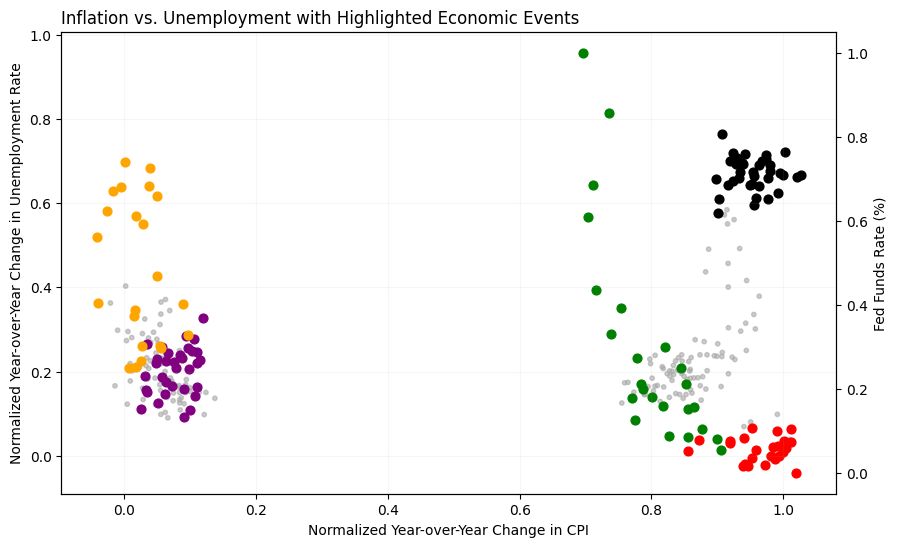

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the datasets
cpi_df = pd.read_csv('CPI_not_seasonally_adjusted.csv')
fed_rate_df = pd.read_csv('FED_FUNDS_RATE.csv')
unemployment_df = pd.read_csv('Unemployment_rate.csv')

# Reshape CPI data to long format and handle special cases
cpi_long = pd.melt(cpi_df, id_vars='Year', var_name='Month', value_name='CPI')
cpi_long = cpi_long[~cpi_long['Month'].isin(['HALF1', 'HALF2'])]
cpi_long['Date'] = pd.to_datetime(cpi_long['Year'].astype(str) + '-' + cpi_long['Month'], format='%Y-%b')

# Calculate YoY percentage change for CPI
cpi_long['YoY_Change_CPI'] = cpi_long['CPI'].pct_change(12) * 100
cpi_long = cpi_long.dropna(subset=['YoY_Change_CPI'])

# Reshape Unemployment data to long format
unemployment_long = pd.melt(unemployment_df, id_vars='Year', var_name='Month', value_name='Unemployment Rate')
unemployment_long['Date'] = pd.to_datetime(unemployment_long['Year'].astype(str) + '-' + unemployment_long['Month'], format='%Y-%b')

# Calculate YoY percentage change for Unemployment Rate
unemployment_long['YoY_Change_Unemployment'] = unemployment_long['Unemployment Rate'].pct_change(12) * 100
unemployment_long = unemployment_long.dropna(subset=['YoY_Change_Unemployment'])

# Convert the DATE column in fed_rate_df to datetime64[ns]
fed_rate_df['DATE'] = pd.to_datetime(fed_rate_df['DATE'])

# Merge datasets
merged_df = pd.merge(cpi_long[['Date', 'YoY_Change_CPI']], unemployment_long[['Date', 'YoY_Change_Unemployment']], on='Date')
merged_df = pd.merge(merged_df, fed_rate_df[['DATE', 'FEDFUNDS']], left_on='Date', right_on='DATE')
merged_df.drop(columns=['DATE'], inplace=True)
merged_df = merged_df.sort_values(by='Date')

# Normalize the YoY Change in CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']])

# Add jitter to the CPI and Unemployment values
jitter_strength = 0.05  # Adjust this value as needed
merged_df['YoY_Change_CPI_Jitter'] = merged_df['YoY_Change_CPI'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_df))
merged_df['YoY_Change_Unemployment_Jitter'] = merged_df['YoY_Change_Unemployment'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_df))

# Define periods of interest with distinct colors and labels with rate action description
highlight_periods = [
    ('2000-01-01', '2002-12-31', 'Dot-com Bubble (cut)', 'purple'),
    ('2008-01-01', '2009-12-31', 'Financial Crisis (cut)', 'orange'),
    ('2010-01-01', '2012-12-31', 'Great Recession Aftermath (maintain)', 'black'),
    ('2020-01-01', '2021-12-31', 'COVID-19 Pandemic (cut)', 'green'),
    ('2022-01-01', '2024-01-01', 'Inflation Surge (hike)', 'red')
]

# Assign a color to each data point based on the date range
merged_df['Event'] = 'Other Points'
merged_df['Color'] = 'darkgrey'

for start, end, event, color in highlight_periods:
    mask = (merged_df['Date'] >= pd.to_datetime(start)) & (merged_df['Date'] <= pd.to_datetime(end))
    merged_df.loc[mask, 'Event'] = event
    merged_df.loc[mask, 'Color'] = color

# Create the scatter plot with secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot all points with jittered values and smaller dots (s=20)
ax1.scatter(merged_df['YoY_Change_CPI_Jitter'], merged_df['YoY_Change_Unemployment_Jitter'],
            c=merged_df['Color'], alpha=0.6, label='Other Points', s=10)

# Plot highlighted events with jitter and smaller dots (s=40)
for event, color in [(event, color) for _, _, event, color in highlight_periods]:
    subset = merged_df[merged_df['Event'] == event]
    ax1.scatter(subset['YoY_Change_CPI_Jitter'], subset['YoY_Change_Unemployment_Jitter'], color=color, label=event, edgecolor=color, s=40)

# Add a secondary y-axis for Fed Funds Rate, but make the line invisible
ax2 = ax1.twinx()
ax2.plot(merged_df['YoY_Change_CPI'], merged_df['FEDFUNDS'], color='none', linewidth=1)
ax2.set_ylabel('Fed Funds Rate (%)')

# Customize the plot
ax1.set_title('Inflation vs. Unemployment with Highlighted Economic Events', loc='left')
ax1.set_xlabel('Normalized Year-over-Year Change in CPI')
ax1.set_ylabel('Normalized Year-over-Year Change in Unemployment Rate')
ax1.grid(True, alpha=0.1)  # Faint grid lines
# ax1.legend(title='Economic Events', loc='upper center', bbox_to_anchor=(0.40, 0.95))

plt.show()


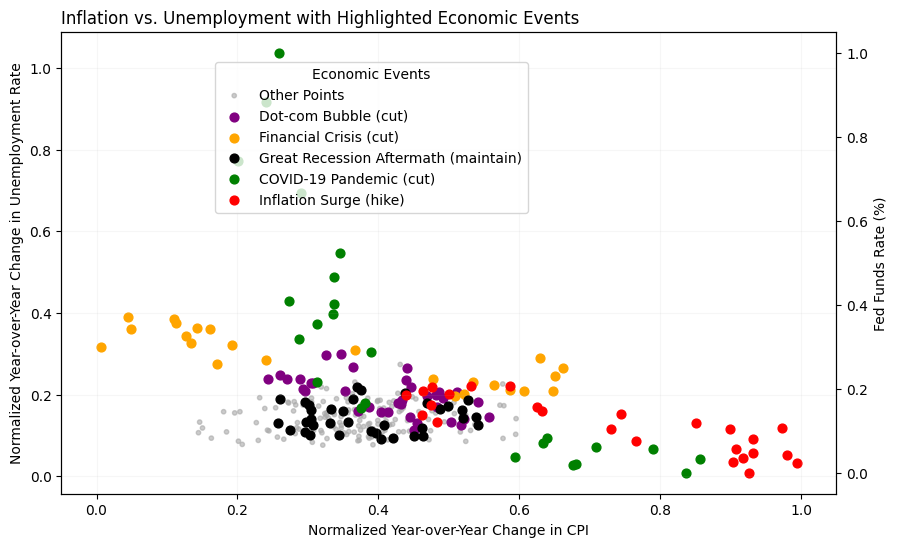

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import yaml
from datetime import datetime
import numpy as np

# Load API key from configuration file
with open("fred_api.yml", 'r') as file:
    config = yaml.safe_load(file)
api_key = config['FRED_API_KEY']

# Define the start date and end date
start_date = '1998-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

# Function to fetch data from FRED API
def fetch_fred_data(series_id, api_key, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'])
        return df[['date', 'value']]
    else:
        raise Exception(f"Error fetching {series_id} data: {response.status_code}")

# Fetch CPI, Unemployment, and Federal Funds Rate data
cpi_data = fetch_fred_data('CPIAUCSL', api_key, start_date, end_date)
unemployment_data = fetch_fred_data('UNRATE', api_key, start_date, end_date)
fedfunds_data = fetch_fred_data('FEDFUNDS', api_key, start_date, end_date)

# Rename columns for easier handling
cpi_data.rename(columns={'value': 'CPI'}, inplace=True)
unemployment_data.rename(columns={'value': 'Unemployment_Rate'}, inplace=True)
fedfunds_data.rename(columns={'value': 'FEDFUNDS'}, inplace=True)

# Calculate YoY Percentage Change for CPI and Unemployment
cpi_data['YoY_Change_CPI'] = cpi_data['CPI'].pct_change(periods=12) * 100
unemployment_data['YoY_Change_Unemployment'] = unemployment_data['Unemployment_Rate'].pct_change(periods=12) * 100

# Drop NA values from YoY percentage change columns
cpi_data = cpi_data.dropna(subset=['YoY_Change_CPI'])
unemployment_data = unemployment_data.dropna(subset=['YoY_Change_Unemployment'])

# Merge the data
merged_df = pd.merge(cpi_data[['date', 'YoY_Change_CPI']], unemployment_data[['date', 'YoY_Change_Unemployment']], on='date')
merged_df = pd.merge(merged_df, fedfunds_data[['date', 'FEDFUNDS']], on='date')

# Normalize the YoY Change in CPI, Unemployment Rate, and Fed Funds Rate using Min-Max scaling
scaler = MinMaxScaler()
merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['YoY_Change_CPI', 'YoY_Change_Unemployment', 'FEDFUNDS']])

# Add jitter to the normalized CPI and Unemployment values
jitter_strength = 0.05  # Adjust this value as needed
merged_df['YoY_Change_CPI_Jitter'] = merged_df['YoY_Change_CPI'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_df))
merged_df['YoY_Change_Unemployment_Jitter'] = merged_df['YoY_Change_Unemployment'] + np.random.uniform(-jitter_strength, jitter_strength, size=len(merged_df))

# Define periods of interest with distinct colors and labels with rate action description
highlight_periods = [
    ('2000-01-01', '2002-12-31', 'Dot-com Bubble (cut)', 'purple'),
    ('2008-01-01', '2009-12-31', 'Financial Crisis (cut)', 'orange'),
    ('2010-01-01', '2012-12-31', 'Great Recession Aftermath (maintain)', 'black'),
    ('2020-01-01', '2021-12-31', 'COVID-19 Pandemic (cut)', 'green'),
    ('2022-01-01', '2024-01-01', 'Inflation Surge (hike)', 'red')
]

# Assign a color to each data point based on the date range
merged_df['Event'] = 'Other Points'
merged_df['Color'] = 'darkgrey'

for start, end, event, color in highlight_periods:
    mask = (merged_df['date'] >= pd.to_datetime(start)) & (merged_df['date'] <= pd.to_datetime(end))
    merged_df.loc[mask, 'Event'] = event
    merged_df.loc[mask, 'Color'] = color

# Create the scatter plot with secondary axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot all points with jittered values and smaller dots (s=20)
ax1.scatter(merged_df['YoY_Change_CPI_Jitter'], merged_df['YoY_Change_Unemployment_Jitter'],
            c=merged_df['Color'], alpha=0.6, label='Other Points', s=10)

# Plot highlighted events with jitter and smaller dots (s=40)
for event, color in [(event, color) for _, _, event, color in highlight_periods]:
    subset = merged_df[merged_df['Event'] == event]
    ax1.scatter(subset['YoY_Change_CPI_Jitter'], subset['YoY_Change_Unemployment_Jitter'], color=color, label=event, edgecolor=color, s=40)

# Add a secondary y-axis for Fed Funds Rate, but make the line invisible
ax2 = ax1.twinx()
ax2.plot(merged_df['YoY_Change_CPI'], merged_df['FEDFUNDS'], color='none', linewidth=1)
ax2.set_ylabel('Fed Funds Rate (%)')

# Customize the plot
ax1.set_title('Inflation vs. Unemployment with Highlighted Economic Events', loc='left')
ax1.set_xlabel('Normalized Year-over-Year Change in CPI')
ax1.set_ylabel('Normalized Year-over-Year Change in Unemployment Rate')
ax1.grid(True, alpha=0.1)  # Faint grid lines
ax1.legend(title='Economic Events', loc='upper center', bbox_to_anchor=(0.40, 0.95))

plt.show()


# 1. Modeling Unemployment as Target using CPI and Fed Funds Rate are Explanatory Variable

We are modeling to determine the relationship between the lagged unemployment rate, CPI, and the Fed Funds Rate, including any combined (interaction) effects. This helps assess how changes in inflation and monetary policy impact unemployment over time, optimizing the lag to better understand delayed effects.

## Multiple linear regression model for a 12-month lag for unemployment using entire dataset
To use a 12-month lag for unemployment in the multiple linear regression model, we directly set the lag to 12 months.

**Key Steps:**
1. The lag is fixed at 12 months using the create_lagged_unemployment function.
2. The multiple linear regression is performed on the 12-month lagged unemployment data, CPI, and the federal funds rate.

This approach directly applies a 12-month lag.

R-squared of the model with 12-month lag: 0.3260462767197312


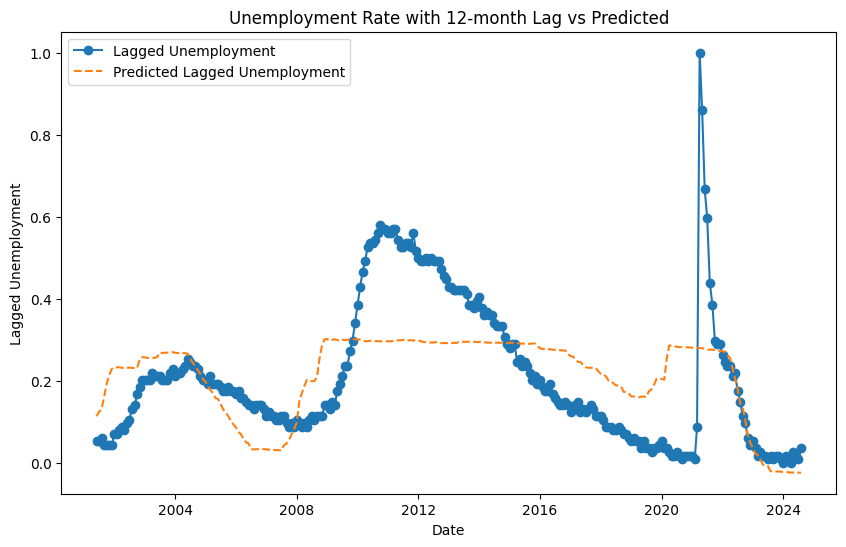

In [11]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01)
start_date = '2000-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to apply a 12-month lag to unemployment data
def create_lagged_unemployment(data, lag=12):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply 12-month lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the 12-month lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df)

# Perform the multiple regression with the lagged unemployment data
X = lagged_data[['CPI', 'FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
print(f'R-squared of the model with 12-month lag: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with 12-month Lag vs Predicted')
plt.legend()
plt.show()


## Multiple Linear regression using optimization to determine the lag parameter of unemployment
To perform multiple regression with a lagged unemployment variable and use optimization to determine the best lag for the unemployment data, we'll follow these steps:

**Key Parts of the Code:**
* **Lagged Unemployment:** The create_lagged_unemployment function shifts the unemployment data by a given number of months. I used 12 months.
* **Optimization:** We use the scipy.optimize.minimize function to find the lag that maximizes the R-squared value of the regression model.
* **Multiple Regression:** The regression model includes CPI and Fed Funds Rate as predictors, and lagged unemployment as the dependent variable.
* **Visualization:** We plot both the actual and predicted lagged unemployment rates to visualize the performance of the model.

Below is the code:

<ipython-input-5-7edd5b089a4a>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer
<ipython-input-5-7edd5b089a4a>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer


Best lag found: 1 months
R-squared of the model with optimal lag: 0.406188013038811


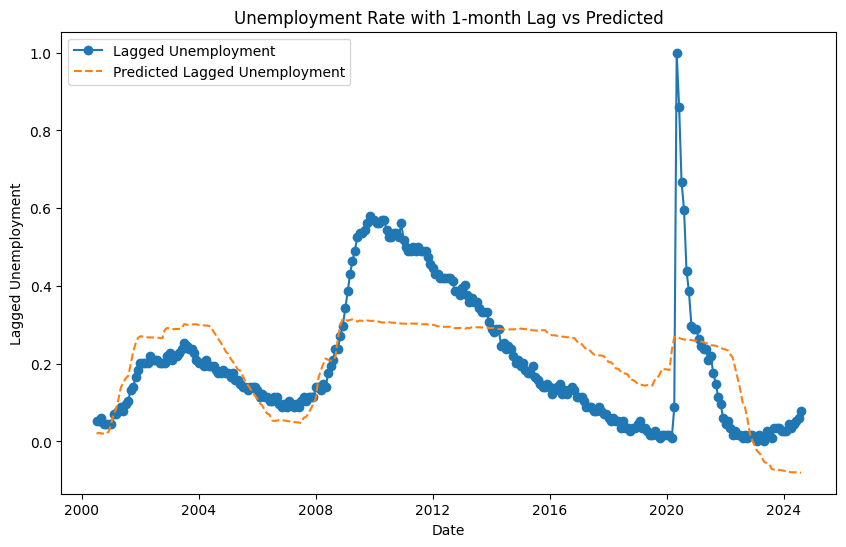

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import requests
from scipy.optimize import minimize

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01)
start_date = '2000-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to shift (lag) the unemployment rate by a given number of months
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Function to compute R-squared for a given lag
def compute_r_squared(lag, data):
    lagged_data = create_lagged_unemployment(data.copy(), lag)
    X = lagged_data[['CPI', 'FEDFUNDS']]  # Independent variables
    y = lagged_data['Lagged_Unemployment']  # Dependent variable (lagged unemployment)

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return -r2_score(y, y_pred)  # We return negative R-squared to minimize

# Optimization to find the best lag
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

best_lag = int(result.x[0])  # Cast result to integer
print(f'Best lag found: {best_lag} months')

# Apply the best lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df, best_lag)

# Perform the multiple regression with the optimal lagged unemployment
X = lagged_data[['CPI', 'FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the optimized model
print(f'R-squared of the model with optimal lag: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with {best_lag}-month Lag vs Predicted')
plt.legend()
plt.show()


## Multiple Linear regression using optimization to determine the lag parameter of unemployment with interaction term

To introduce an interaction term into the model, we need to create a new feature that is the interaction between CPI and Fed Funds Rate. The interaction term will capture any combined effect of these two variables on the lagged unemployment rate.

**Key Additions:**
1. **Interaction Term:** We create a new feature called CPI_FEDFUNDS_Interaction, which is the product of CPI and Fed Funds Rate. This term captures any combined effects of CPI and Fed Funds Rate on unemployment.
2. **Lag Optimization:** We still use scipy.optimize.minimize to find the optimal lag for unemployment. The optimization is based on minimizing the negative R-squared value, ensuring that the best lag is selected.
3. **Multiple Regression Model:** The model now includes the interaction term, along with CPI and Fed Funds Rate, as predictors.

**Output:**
* **Optimal Lag:** The optimization process will determine the best lag to use for the unemployment data.
* **R-Squared Value:** This will indicate how well the model, including the interaction term, fits the lagged unemployment data.
8 **Plot:** A line plot comparing the lagged unemployment data and the predicted unemployment based on the model. The plot helps visualize how well the model fits the lagged unemployment data.

This approach effectively uses both individual factors (CPI, Fed Funds Rate) and their interaction to explain unemployment, accounting for lagged effects.

Here's the updated code with the interaction term:

<ipython-input-10-be9394275add>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer
<ipython-input-10-be9394275add>:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer


Best lag found: 1 months
R-squared of the model with optimal lag and interaction term: 0.43158123358140954


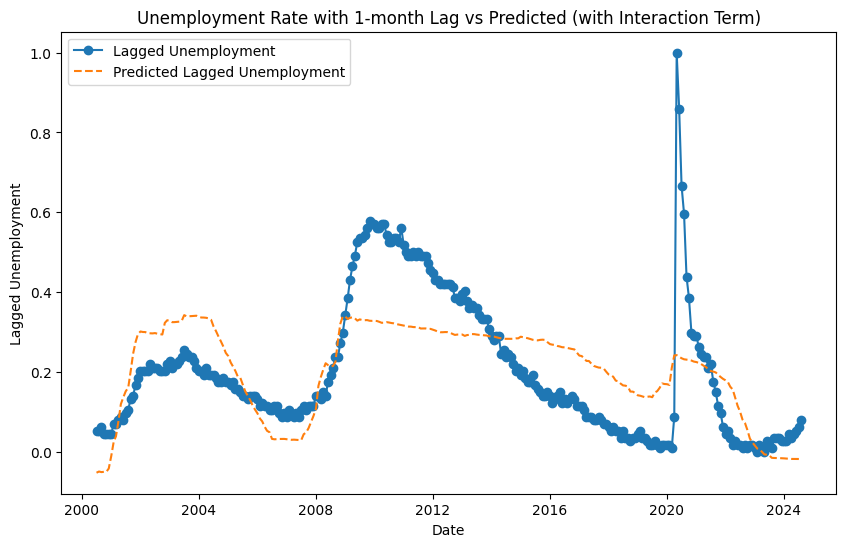

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import requests
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01)
start_date = '2000-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Add interaction term (CPI * FEDFUNDS)
merged_df['CPI_FEDFUNDS_Interaction'] = merged_df['CPI'] * merged_df['FEDFUNDS']

# Function to shift (lag) the unemployment rate by a given number of months
def create_lagged_unemployment(data, lag):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(int(lag))  # Cast lag to integer
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Function to compute R-squared for a given lag with the interaction term
def compute_r_squared(lag, data):
    lagged_data = create_lagged_unemployment(data.copy(), lag)
    X = lagged_data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]  # Include interaction term
    y = lagged_data['Lagged_Unemployment']  # Dependent variable (lagged unemployment)

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    return -r2_score(y, y_pred)  # We return negative R-squared to minimize

# Optimization to find the best lag
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

best_lag = int(result.x[0])  # Cast result to integer
print(f'Best lag found: {best_lag} months')

# Apply the best lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df, best_lag)

# Perform the multiple regression with the optimal lagged unemployment and interaction term
X = lagged_data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the optimized model with interaction term
print(f'R-squared of the model with optimal lag and interaction term: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with {best_lag}-month Lag vs Predicted (with Interaction Term)')
plt.legend()
plt.show()


## Modeling the Dot-com Bubble Burst with Multiple Linear Regression with unemployment lagged by 12 months (2000-06-01 to 2004-06-01)

R-squared of the model with 12-month lag: 0.8967516017462795


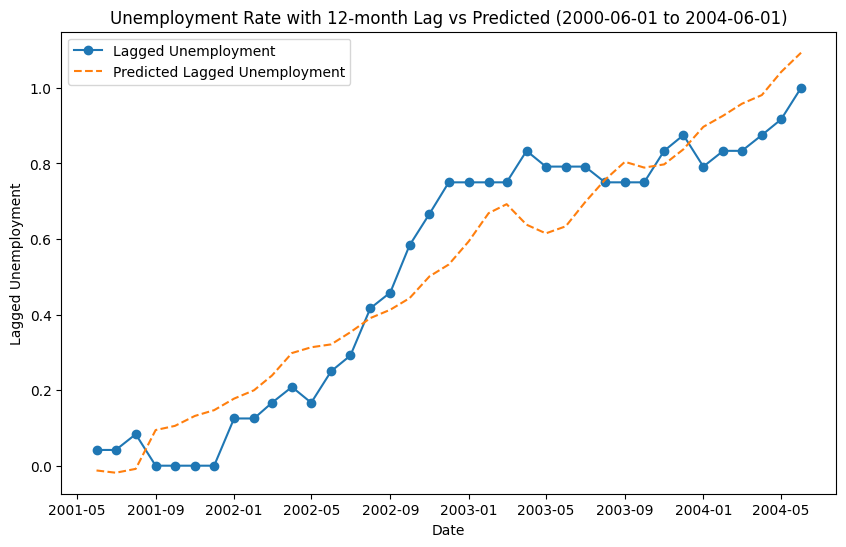

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2004-06-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to apply a 12-month lag to unemployment data
def create_lagged_unemployment(data, lag=12):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply 12-month lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the 12-month lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df)

# Perform the multiple regression with the lagged unemployment data
X = lagged_data[['CPI', 'FEDFUNDS']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
print(f'R-squared of the model with 12-month lag: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with 12-month Lag vs Predicted (2000-06-01 to 2004-06-01)')
plt.legend()
plt.show()


## Multiple Linear Regression with lagged unemployment lagged by 12 months using interaction term between cpi and Fed Funds Rate

To introduce an interaction term in the multiple regression model, I included a term that multiplies two of the predictor variables (e.g., CPI and FEDFUNDS) and use this new term in the regression. Below is the code to include an interaction term between the CPI and FEDFUNDS variables:

**Key Additions:**
1. Interaction Term: The interaction term is created using lagged_data['CPI'] * lagged_data['FEDFUNDS'] and added as an additional predictor in the regression model.
2. Multiple Regression: The independent variables (CPI, FEDFUNDS, and their interaction) are used to predict the lagged unemployment data.
3. R-Squared: The R-squared value of the model is printed to evaluate how well the model explains the variance in the lagged unemployment data.

**Why Use an Interaction Term?**
The interaction term captures the effect of the joint relationship between CPI and Fed Funds Rate on unemployment. It shows how the relationship between unemployment and CPI might change depending on the level of the Fed Funds Rate, and vice versa.

This visualization and model will allow you to examine how the interaction between CPI and Fed Funds Rate might impact unemployment, especially with a 12-month lag.

R-squared of the model with interaction term: 0.9145860641838789


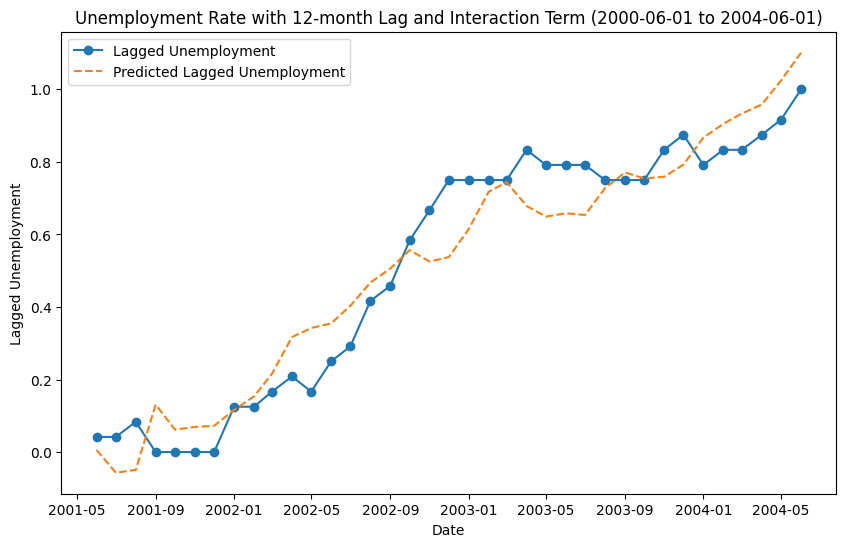

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2004-06-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values (just in case)
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Function to apply a 12-month lag to unemployment data
def create_lagged_unemployment(data, lag=12):
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)  # Apply 12-month lag
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging
    return data

# Apply the 12-month lag to the unemployment data
lagged_data = create_lagged_unemployment(merged_df)

# Create an interaction term between CPI and FEDFUNDS
lagged_data['CPI_FEDFUNDS_Interaction'] = lagged_data['CPI'] * lagged_data['FEDFUNDS']

# Perform the multiple regression with the lagged unemployment data and the interaction term
X = lagged_data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = lagged_data['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
print(f'R-squared of the model with interaction term: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(lagged_data['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(lagged_data['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with 12-month Lag and Interaction Term (2000-06-01 to 2004-06-01)')
plt.legend()
plt.show()


## Multiple Linear Regression incorporating an interaction term and optimize the lag for the unemployment data
To incorporate an interaction term and optimize the lag for the unemployment data in a multiple regression model, we need to perform the following steps:

* Define an optimization function to determine the best lag.
* Fit a multiple regression model using the lagged unemployment data and the interaction term.
* Find the optimal lag by minimizing a cost function, such as the negative R-squared value.

The updated process involves:

* Creating lagged unemployment data for different lags.
* Creating an interaction term between CPI and Fed Funds Rate.
* Optimizing the lag using an optimization algorithm (e.g., scipy.optimize.minimize).

Here’s the Python code that implements this:

**Key Changes:**
1. **Optimization of Lag:** We use the minimize function from scipy.optimize to find the optimal lag (between 1 and 12 months) by minimizing the negative R-squared value.
2. **Interaction Term:** An interaction term is created between CPI and FEDFUNDS and included in the multiple regression model.
3. **R-Squared Calculation:** The R-squared value is calculated to determine how well the model fits the data with the optimized lag.

**Explanation:**
* The interaction term (CPI * FEDFUNDS) captures how the combined effect of CPI and the Fed Funds Rate influences unemployment.
* The lag optimization ensures that we find the best delay between unemployment changes and the other predictors (CPI and Fed Funds Rate).
* R-squared helps evaluate how well the lagged model with the interaction term explains unemployment.

This model and visualization can be used to analyze the relationship between CPI, Fed Funds Rate, and unemployment over time, factoring in delayed effects.

<ipython-input-9-4c1b289438e1>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-9-4c1b289438e1>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag: 1 months
R-squared of the model with interaction term and optimized lag: 0.9497586094669342


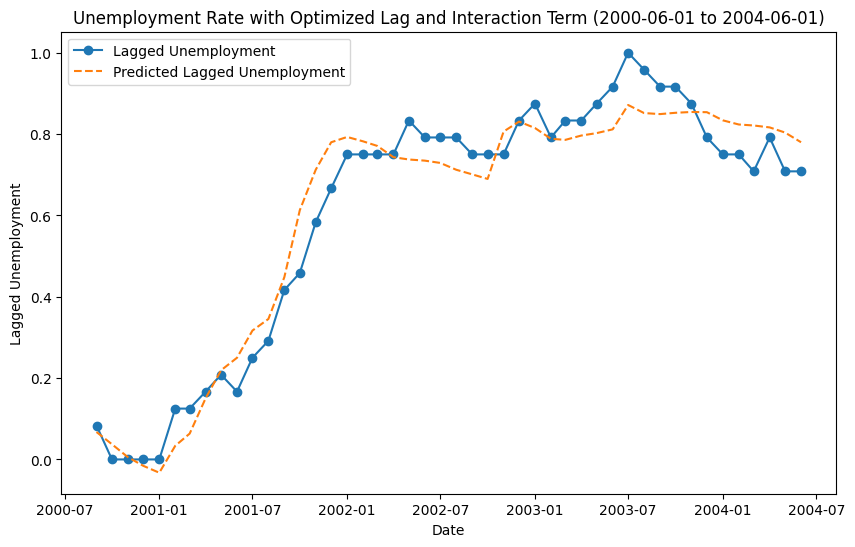

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2004-06-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between CPI and FEDFUNDS
merged_df['CPI_FEDFUNDS_Interaction'] = merged_df['CPI'] * merged_df['FEDFUNDS']

# Function to apply a lag to unemployment data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_Unemployment'] = data['Unemployment Rate'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
    y = data['Lagged_Unemployment']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag: {best_lag} months')

# Apply the best lag to the dataset
merged_df['Lagged_Unemployment'] = merged_df['Unemployment Rate'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged unemployment data and the interaction term
X = merged_df[['CPI', 'FEDFUNDS', 'CPI_FEDFUNDS_Interaction']]
y = merged_df['Lagged_Unemployment']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
print(f'R-squared of the model with interaction term and optimized lag: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged Unemployment', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged Unemployment', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged Unemployment')
plt.title(f'Unemployment Rate with Optimized Lag and Interaction Term (2000-06-01 to 2004-06-01)')
plt.legend()
plt.show()


## Multiple Linear Regression Model of lagged CPI as Target Variable and unemployment and Fed Funds Rate as the explanatory variables
Here's how we can model lagged CPI as the target variable while keeping unemployment and Fed Funds Rate as the explanatory variables.

**Explanation:**
1. **Target Variable (CPI):** In this case, the model targets lagged CPI as the dependent variable.
2. **Explanatory Variables:** The independent variables are Unemployment Rate, Fed Funds Rate, and their interaction term (Unemployment Rate * Fed Funds Rate).
3. **Lag Optimization:** We use the minimize function from scipy.optimize to find the optimal lag for CPI.
4. **Multiple Regression:** Once the optimal lag is determined, a linear regression is performed using the interaction term as part of the model.
5. **Plot:** The plot shows the actual lagged CPI and the predicted values over time.

This setup allows us to understand how unemployment and the Fed Funds Rate affect future (lagged) inflation.

<ipython-input-14-32212fefcac1>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-14-32212fefcac1>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag for CPI: 1 months
R-squared of the model with interaction term and optimized lag: 0.8832601447426902


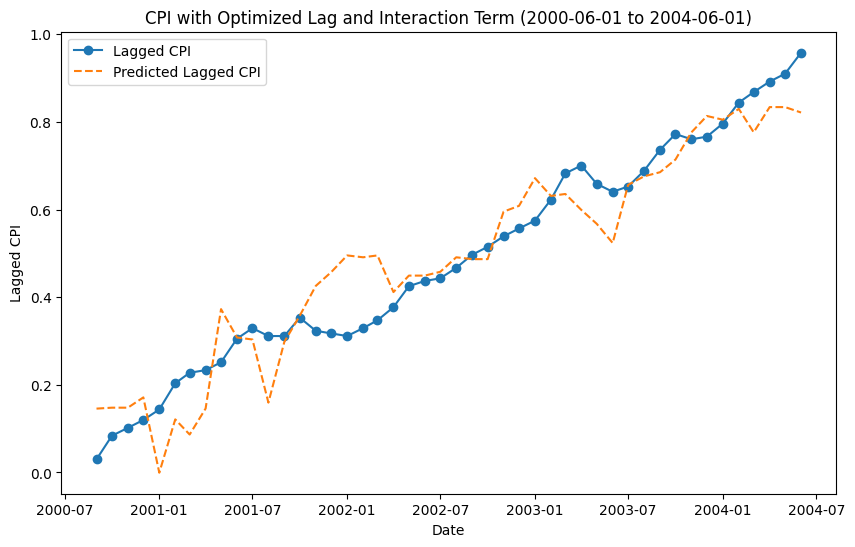

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2004-06-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between Unemployment Rate and FEDFUNDS
merged_df['Unemployment_FEDFUNDS_Interaction'] = merged_df['Unemployment Rate'] * merged_df['FEDFUNDS']

# Function to apply a lag to CPI data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_CPI'] = data['CPI'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
    y = data['Lagged_CPI']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag for CPI: {best_lag} months')

# Apply the best lag to the CPI data
merged_df['Lagged_CPI'] = merged_df['CPI'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged CPI data and the interaction term
X = merged_df[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
y = merged_df['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
print(f'R-squared of the model with interaction term and optimized lag: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged CPI', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with Optimized Lag and Interaction Term (2000-06-01 to 2004-06-01)')
plt.legend()
plt.show()


## Multiple Linear Regression Model of lagged CPI as Target Variable and unemployment and Fed Funds Rate as the explanatory variables together with interaction between unemployment and Fed Funds Rate

### **Key Adjustments:**
1. **Target Variable**: The **lagged CPI** is used as the target variable (dependent variable).
2. **Explanatory Variables**: The explanatory variables are **Unemployment Rate**, **Fed Funds Rate**, and their interaction term.
3. **Lag Optimization**: The `minimize` function is used to determine the optimal lag for CPI (from 1 to 12 months).
4. **Multiple Regression**: Once the optimal lag for CPI is determined, the model is trained on the features and the lagged CPI.

This setup helps in analyzing how the unemployment rate and Fed Funds Rate (along with their interaction) affect future CPI values.

### **Key Finding:**
The interaction term has no impact on the model performance based on R-Squared

<ipython-input-15-32212fefcac1>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)
<ipython-input-15-32212fefcac1>:62: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lag = int(lag)


Optimal Lag for CPI: 1 months
R-squared of the model with interaction term and optimized lag: 0.8832601447426902


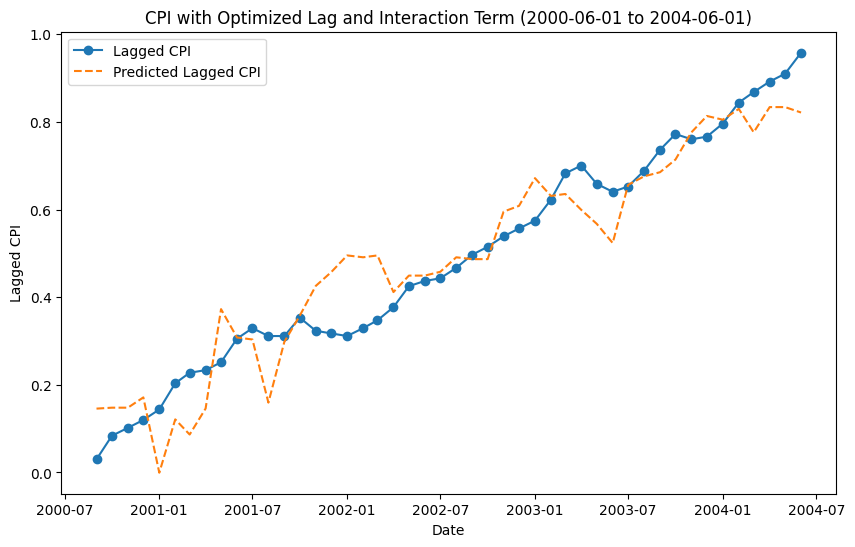

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests

# Function to retrieve data from the FRED API
def get_fred_data(series_id, api_key, start_date='1998-01-01', end_date='2004-06-01'):
    url = f"https://api.stlouisfed.org/fred/series/observations"
    params = {
        'series_id': series_id,
        'api_key': api_key,
        'file_type': 'json',
        'observation_start': start_date,
        'observation_end': end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()['observations']
        df = pd.DataFrame(data)
        df['Date'] = pd.to_datetime(df['date'])
        df['value'] = pd.to_numeric(df['value'], errors='coerce')
        return df[['Date', 'value']]
    else:
        raise Exception(f"Error fetching data from FRED API: {response.status_code}")

# Set your FRED API key here
api_key = '7913092cb97545d7c236897b524805da'  # Replace with your actual FRED API key

# Retrieve data from FRED API (starting from 2000-06-01 to 2004-06-01)
start_date = '2000-06-01'
end_date = '2004-06-01'
cpi_df = get_fred_data('CPIAUCSL', api_key, start_date, end_date)  # Consumer Price Index
unemployment_df = get_fred_data('UNRATE', api_key, start_date, end_date)  # Unemployment Rate
fed_rate_df = get_fred_data('FEDFUNDS', api_key, start_date, end_date)  # Federal Funds Rate

# Rename columns for clarity
cpi_df.columns = ['Date', 'CPI']
unemployment_df.columns = ['Date', 'Unemployment Rate']
fed_rate_df.columns = ['Date', 'FEDFUNDS']

# Merge datasets on the Date column
merged_df = pd.merge(cpi_df, unemployment_df, on='Date')
merged_df = pd.merge(merged_df, fed_rate_df, on='Date')

# Drop any missing values
merged_df.dropna(inplace=True)

# Normalize the CPI, Unemployment Rate, and Fed Funds Rate using MinMaxScaler
scaler = MinMaxScaler()
merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']] = scaler.fit_transform(
    merged_df[['CPI', 'Unemployment Rate', 'FEDFUNDS']])

# Create an interaction term between Unemployment Rate and FEDFUNDS
merged_df['Unemployment_FEDFUNDS_Interaction'] = merged_df['Unemployment Rate'] * merged_df['FEDFUNDS']

# Function to apply a lag to CPI data and calculate R-squared
def compute_r_squared(lag, data):
    lag = int(lag)
    data['Lagged_CPI'] = data['CPI'].shift(lag)
    data.dropna(inplace=True)  # Drop rows with NaN values due to lagging

    X = data[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
    y = data['Lagged_CPI']

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Return the negative R-squared to minimize
    return -r2_score(y, y_pred)

# Optimization to find the best lag (from 1 month to 12 months)
result = minimize(compute_r_squared, x0=1, args=(merged_df,), bounds=[(1, 12)], method='L-BFGS-B')

# Get the best lag value
best_lag = int(result.x[0])
print(f'Optimal Lag for CPI: {best_lag} months')

# Apply the best lag to the CPI data
merged_df['Lagged_CPI'] = merged_df['CPI'].shift(best_lag)
merged_df.dropna(inplace=True)

# Perform the multiple regression with the lagged CPI data and the interaction term
X = merged_df[['Unemployment Rate', 'FEDFUNDS', 'Unemployment_FEDFUNDS_Interaction']]
y = merged_df['Lagged_CPI']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Print the R-squared value of the model
print(f'R-squared of the model with interaction term and optimized lag: {r2_score(y, y_pred)}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], y, label='Lagged CPI', marker='o')
plt.plot(merged_df['Date'], y_pred, label='Predicted Lagged CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Lagged CPI')
plt.title(f'CPI with Optimized Lag and Interaction Term (2000-06-01 to 2004-06-01)')
plt.legend()
plt.show()
